2024-08-15 21:07:44,898 - INFO - Successfully read the file
2024-08-15 21:07:51,935 - INFO - Epoch 1/100, Loss: 0.0052
2024-08-15 21:07:52,090 - INFO - Epoch 2/100, Loss: 0.0027
2024-08-15 21:07:52,254 - INFO - Epoch 3/100, Loss: 0.0027
2024-08-15 21:07:52,443 - INFO - Epoch 4/100, Loss: 0.0033
2024-08-15 21:07:52,608 - INFO - Epoch 5/100, Loss: 0.0014
2024-08-15 21:07:52,783 - INFO - Epoch 6/100, Loss: 0.0027
2024-08-15 21:07:52,961 - INFO - Epoch 7/100, Loss: 0.0083
2024-08-15 21:07:53,126 - INFO - Epoch 8/100, Loss: 0.0060
2024-08-15 21:07:53,319 - INFO - Epoch 9/100, Loss: 0.0014
2024-08-15 21:07:53,515 - INFO - Epoch 10/100, Loss: 0.0005
2024-08-15 21:07:53,670 - INFO - Epoch 11/100, Loss: 0.0035
2024-08-15 21:07:53,907 - INFO - Epoch 12/100, Loss: 0.0055
2024-08-15 21:07:54,083 - INFO - Epoch 13/100, Loss: 0.0011
2024-08-15 21:07:54,254 - INFO - Epoch 14/100, Loss: 0.0012
2024-08-15 21:07:54,353 - INFO - Epoch 15/100, Loss: 0.0085
2024-08-15 21:07:54,478 - INFO - Epoch 16/100, Lo

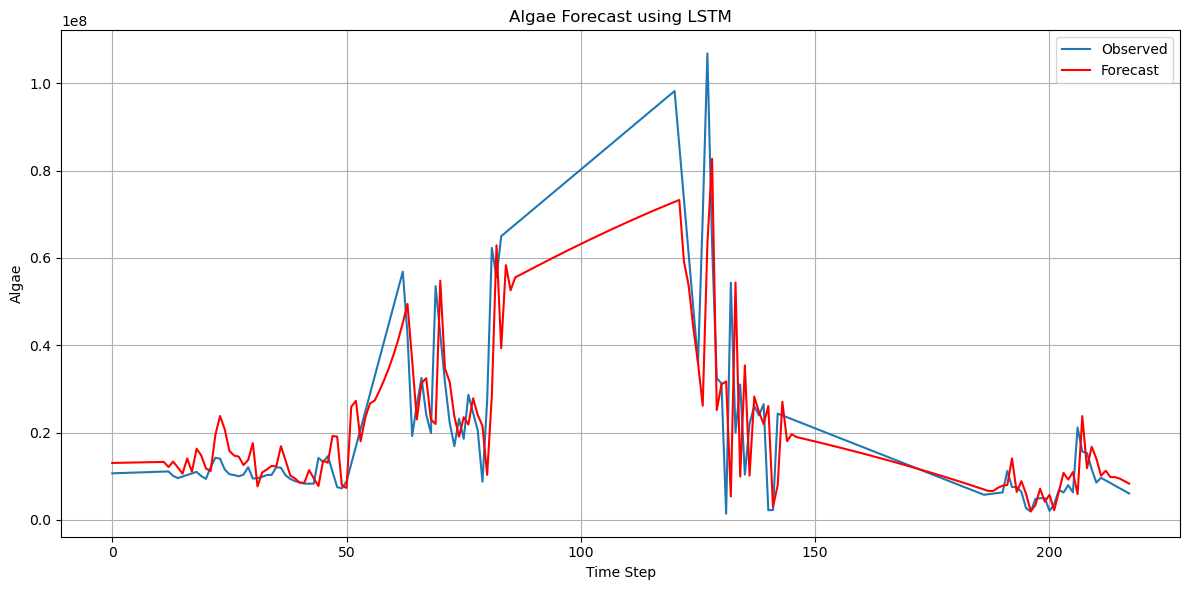

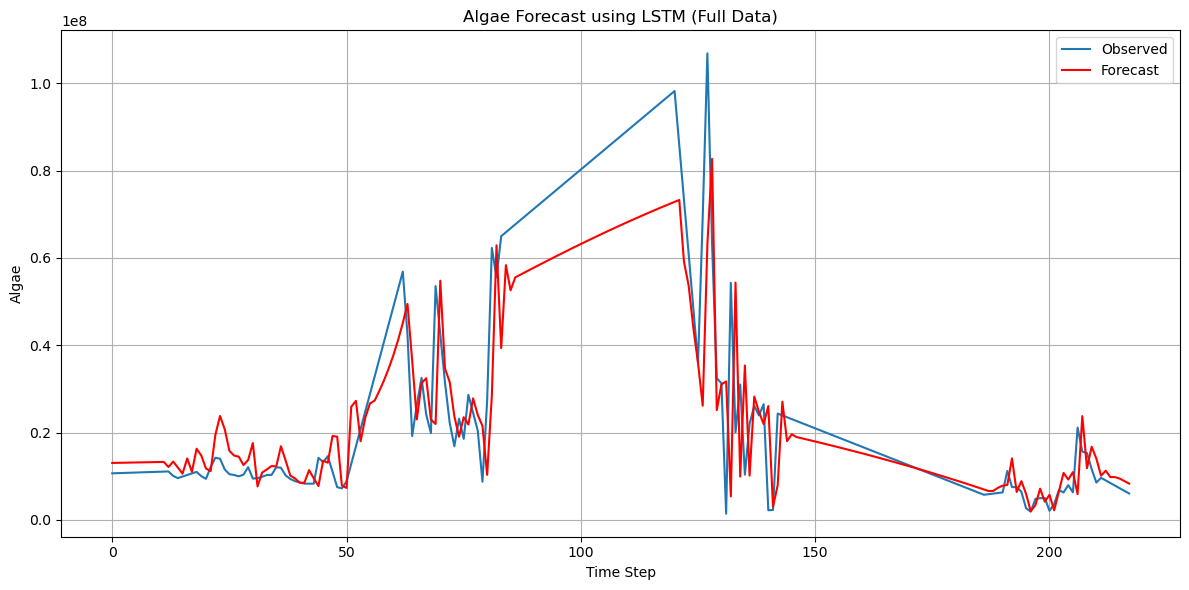

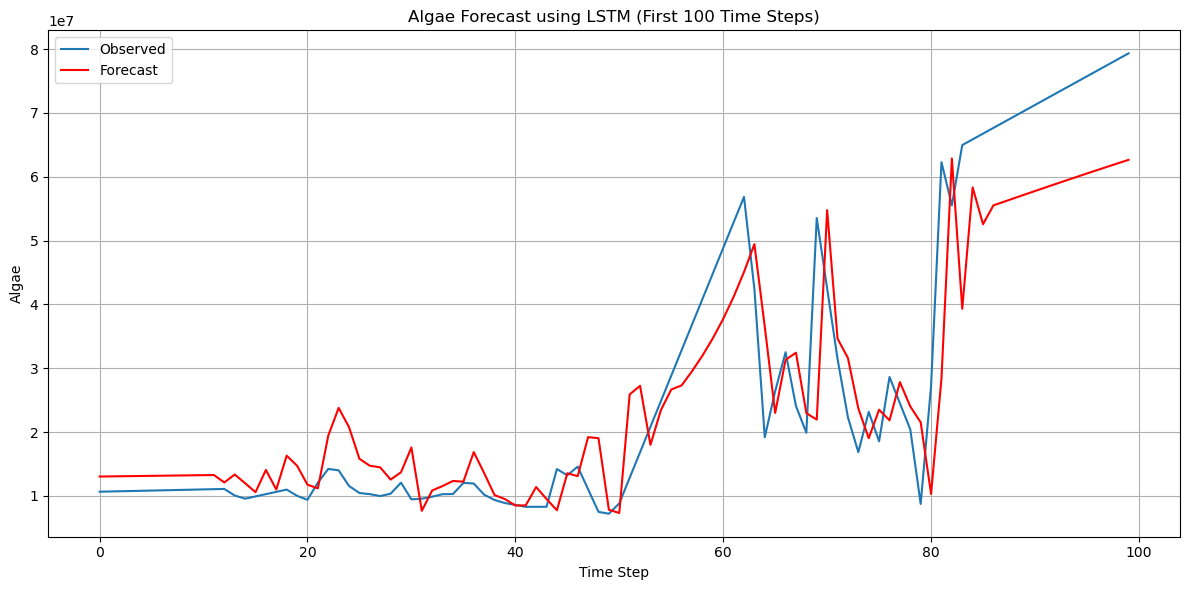

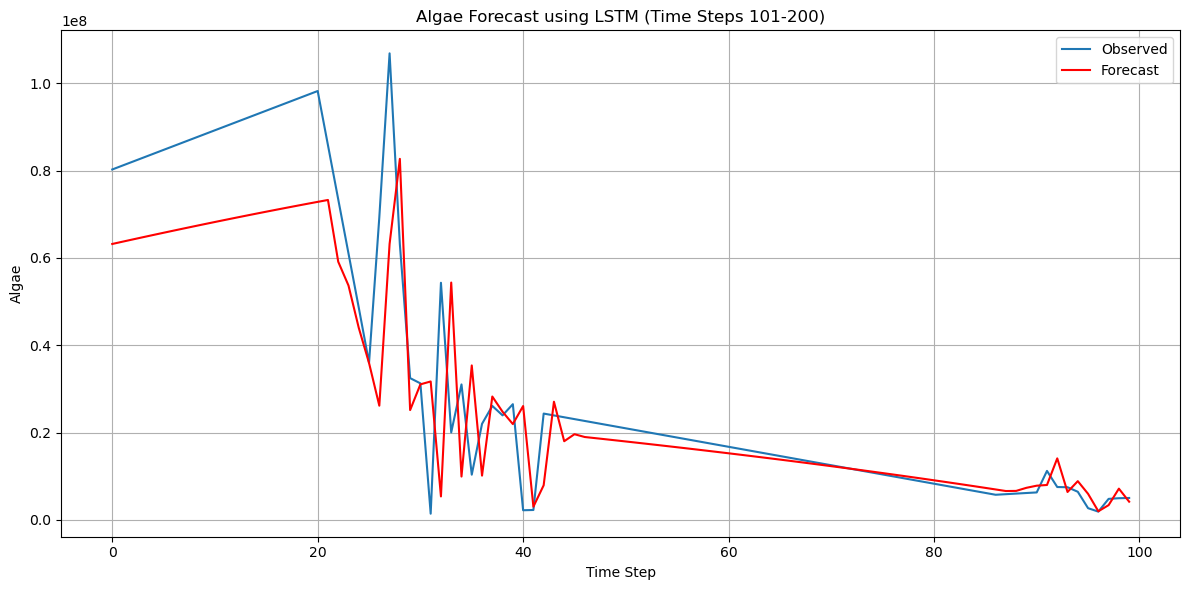

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def preprocess_data(df, sequence_length):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.ffill()

    features = ['temp', 'oxygen', 'NH3', 'TP', 'TN', 'algae']
    df_features = df[features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=features, index=df.index)

    # Create sequences
    data = []
    for i in range(len(df_scaled) - sequence_length):
        data.append(df_scaled.iloc[i:i+sequence_length].values)
    data = np.array(data)

    # Split into inputs and targets
    X = data[:, :-1, :]
    y = data[:, -1, features.index('algae')]

    return X, y, scaler

def create_dataloaders(X, y, batch_size, train_size=0.8):
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
        logging.info(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.squeeze().numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Algae Forecast using LSTM', xlabel='Time Step', ylabel='Algae', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
    plt.figure(figsize=(12, 6))
    plt.plot(targets[start_idx:end_idx], label='Observed')
    plt.plot(predictions[start_idx:end_idx], label='Forecast', color='red')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv', encoding='utf-8')
        logging.info("Successfully read the file")

        sequence_length = 5  # Number of previous time steps to consider for prediction
        X, y, scaler = preprocess_data(df, sequence_length)

        batch_size = 16
        train_loader, test_loader = create_dataloaders(X, y, batch_size)

        input_size = X.shape[2]  # Number of features
        hidden_size = 64
        num_layers = 2
        output_size = 1

        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        epochs = 100

        train_lstm_model(model, train_loader, criterion, optimizer, epochs)

        predictions, targets = evaluate_lstm_model(model, test_loader)

        # Inverse transform the predictions and targets
        predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), 5)), predictions.reshape(-1, 1)), axis=1))[:, 5]
        targets = scaler.inverse_transform(np.concatenate((np.zeros((len(targets), 5)), targets.reshape(-1, 1)), axis=1))[:, 5]

        rmse = np.sqrt(mean_squared_error(targets, predictions))
        mae = mean_absolute_error(targets, predictions)
        logging.info(f"\nForecast Accuracy:")
        logging.info(f"RMSE: {rmse:.4f}")
        logging.info(f"MAE: {mae:.4f}")

        # Plot the forecast
        plt.figure(figsize=(12, 6))
        plt.plot(targets, label='Observed')
        plt.plot(predictions, label='Forecast', color='red')
        plt.title('Algae Forecast using LSTM')
        plt.xlabel('Time Step')
        plt.ylabel('Algae')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # Plot the forecast for different segments
        plot_forecast(targets, predictions, title='Algae Forecast using LSTM (Full Data)')

        # Example: Plot the forecast for the first 100 time steps
        plot_forecast(targets, predictions, title='Algae Forecast using LSTM (First 100 Time Steps)', end_idx=100)

        # Example: Plot the forecast for the next 100 time steps
        plot_forecast(targets, predictions, title='Algae Forecast using LSTM (Time Steps 101-200)', start_idx=100, end_idx=200)

        # You can add more plots for different segments as needed

    except Exception as e:
        logging.error(f"An error occurred in main: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()